un Recommendeur de joueurs similaires. Le but est de trouver des joueurs qui ont un style ou des performances proches d’un joueur donné


PCA : pour réduire la dimensionnalité des données.

KMeans : pour grouper les joueurs selon leurs styles.

Cosine similarity : pour mesurer leur "distance" réelle dans l'espace de stats.

In [26]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_excel("merged_players.xlsx")

To build a Player Similarity Recommender, you should only include features that describe the player's profile and style of play, not features that are:

Target-specific like value_m (market value),

Match-specific outcomes like wins, points, etc.,

Identifiers or categorical strings (unless encoded).

In [27]:


# Select relevant numeric features (exclude name, team, league, etc.)
features = [
    'ballcontrol', 'vision', 'finishing', 'balance',
    'agility', 'sprintspeed',  'reactions',
    'positioning', 'marking', 'standingtackle', 'slidingtackle',
    'interceptions', 'headingaccuracy', 'volleys',
    'longshots', 'curve', 'fkaccuracy', 'longpassing',
    'crossing', 'shortpassing', 'dribbling','shotpower', 'strength', 'penalties'

]

player_info = df[['name', 'team', 'league']]  # For display
X = df[features].copy()


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [29]:
from sklearn.decomposition import PCA
X_cleaned = X.dropna()
pca = PCA(n_components=10)# Reduce to 5D for clustering
X_pca = pca.fit_transform(X_cleaned)
df_cleaned = df.loc[X_cleaned.index].reset_index(drop=True)


Analyse du graphique (Variance expliquée cumulée par PCA)

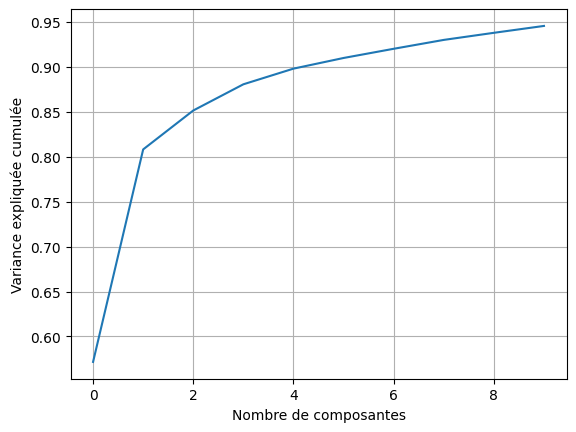

In [30]:
from matplotlib import pyplot as plt
import numpy as np


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True)
plt.show()


Après avoir appliqué une réduction de dimensionnalité via l'algorithme PCA, nous avons observé que les 6 premières composantes principales suffisent à expliquer plus de 95 % de la variance des données d’entrée.



Lecture :

L’axe Y montre la variance expliquée cumulée.

L’axe X montre le nombre de composantes principales (PCA).

Tu atteins environ 95% de variance expliquée en 6 composantes.

Après la 6e composante, les gains sont marginaux.

6 composantes principales suffisent pour représenter tes données tout en conservant l’essentiel de la variance (95%).

Pour verifier de plus on va utiliser le Scree Plot (éboulis)

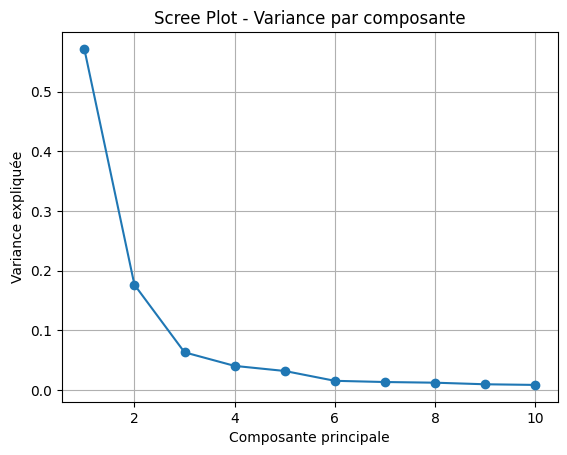

In [50]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot - Variance par composante")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée")
plt.grid(True)
plt.show()


Interprétation du Scree Plot

La 1re composante explique plus de 55 % de la variance à elle seule → énorme.

La 2e composante ≈ 17–18 %.

Ensuite, la variance chute très vite.

À partir de la 6e composante, la contribution devient quasi nulle (< 2 %) par composante.

 Conclusion

Le coude est très net à la composante 2 ou 3, et la courbe devient quasi plate dès la 6e composante.

Donc :

6 composantes principales est un excellent choix.

Tu captures déjà presque toute l'information utile, et les suivantes n’apportent presque rien.

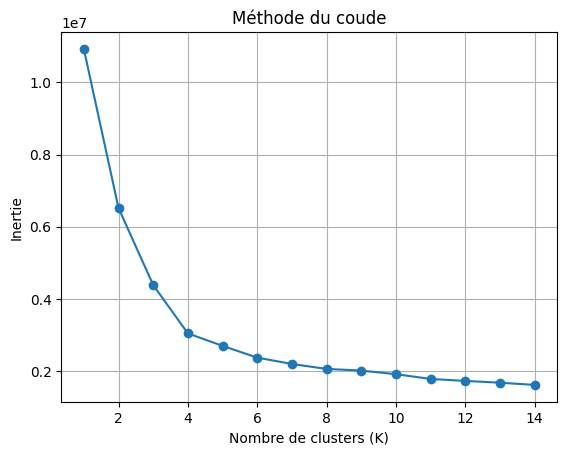

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie")
plt.title("Méthode du coude")
plt.grid(True)
plt.show()


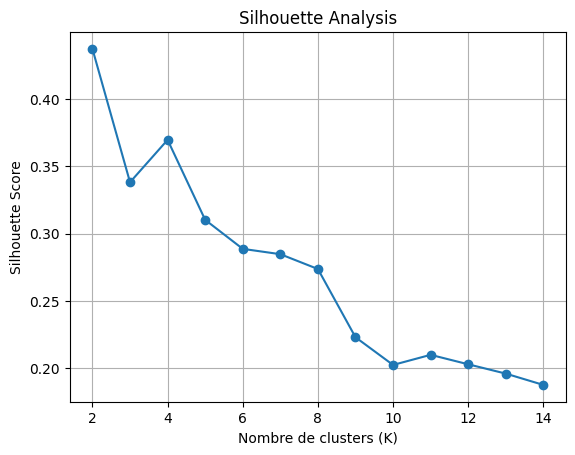

In [32]:
from sklearn.metrics import silhouette_score

scores = []
K_range = range(2, 15)  # K=1 est exclu (silhouette non défini)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append(score)

plt.plot(K_range, scores, marker='o')
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.grid(True)
plt.show()


Chaque cluster représente un "profil-type" de joueur, basé sur les statistiques utilisées (physiques, techniques, performances...).

In [33]:
# Aligner df avec X_cleaned
from sklearn.cluster import KMeans

df_cleaned = df.loc[X_cleaned.index].reset_index(drop=True)

# Pipeline
X_scaled = scaler.fit_transform(X_cleaned)
X_pca = pca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Ajout des clusters
df_cleaned['cluster'] = clusters


In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_players(player_name, top_n=5):
    idx = df_cleaned[df_cleaned['name'] == player_name].index[0]
    player_vector = X_scaled[idx].reshape(1, -1)
    
    similarities = cosine_similarity(player_vector, X_scaled).flatten()
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]

    return df_cleaned.loc[similar_indices, ['name', 'team', 'league', 'cluster']], similarities[similar_indices]


In [35]:
# Replace with a real player name in your dataset
similar_players, scores = find_similar_players("kylian_mbappe", top_n=5)
print(similar_players)
print("Similarity Scores:", scores)


                   name             team          league  cluster
30           leroy_sane           bayern      bundesliga        1
794       mohamed_salah        liverpool  premier_league        1
903     marcus_rashford      aston_villa  premier_league        1
1430     alexis_sanchez          udinese         serie_a        1
293   antoine_griezmann  atletico_madrid         la_liga        1
Similarity Scores: [0.96133842 0.96073933 0.95836874 0.95821411 0.95023949]


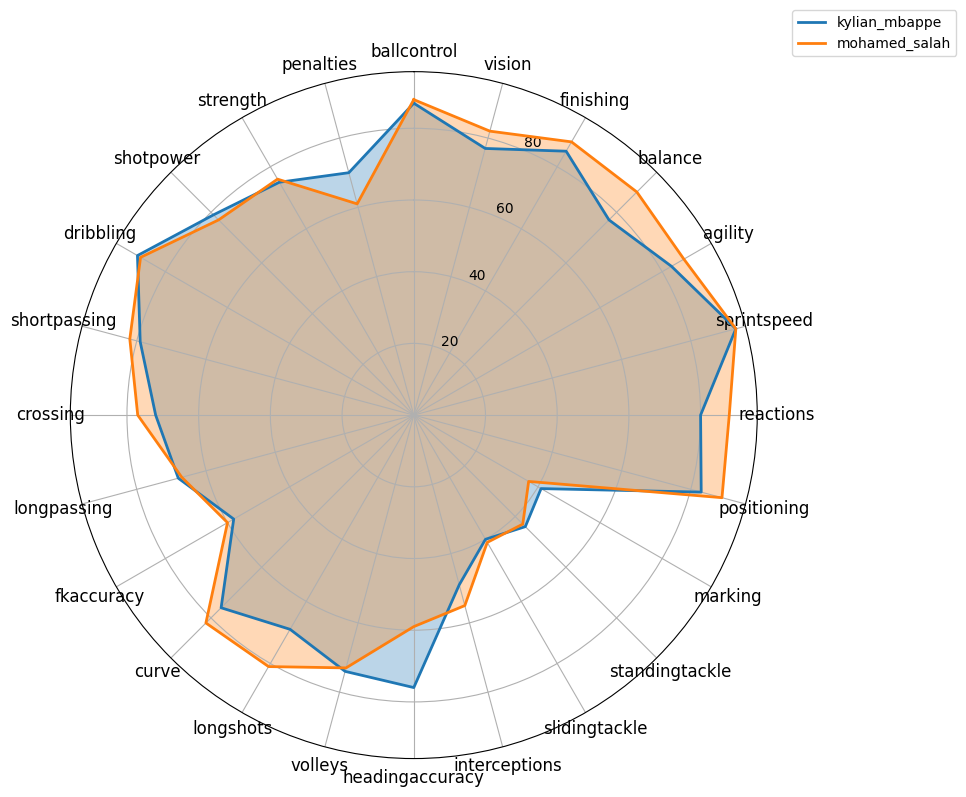

In [56]:
from matplotlib import pyplot as plt
import numpy as np

def radar_plot(player1_name, player2_name):
    if player1_name not in df_cleaned['name'].values or player2_name not in df_cleaned['name'].values:
        print("❌ L’un des noms n'existe pas dans df_cleaned['name']")
        return

    idx1 = df_cleaned[df_cleaned['name'] == player1_name].index[0]
    idx2 = df_cleaned[df_cleaned['name'] == player2_name].index[0]

    stats1 = X_cleaned.iloc[idx1].values
    stats2 = X_cleaned.iloc[idx2].values

    labels = features
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # pour boucler

    stats1 = np.concatenate((stats1, [stats1[0]]))
    stats2 = np.concatenate((stats2, [stats2[0]]))

    # ✅ Créer la figure en grand
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    ax.plot(angles, stats1, label=player1_name, linewidth=2)
    ax.fill(angles, stats1, alpha=0.3)

    ax.plot(angles, stats2, label=player2_name, linewidth=2)
    ax.fill(angles, stats2, alpha=0.3)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)

    plt.tight_layout()
    plt.show()

# Exemple d’utilisation
radar_plot("kylian_mbappe", "mohamed_salah")


In [37]:
import joblib

#joblib.dump(kmeans, "models/kmeans_model.pkl")
#joblib.dump(scaler, "models/scaler.pkl")
#joblib.dump(pca, "models/pca.pkl")
#df.to_csv("data/clustered_players.csv", index=False)

On va comparer KMeans avec un autre modèle plus performant qui va nous permettre de détecter des groupes plus naturels et moins contraints que ceux imposés par KMeans




Modèle alternatif recommandé : HDBSCAN
(Hiérarchical Density-Based Spatial Clustering of Applications with Noise)

Pourquoi HDBSCAN ?

Il détecte des clusters de densité sans avoir besoin de spécifier K.

Il gère les formes irrégulières, les outliers, et les groupes de tailles inégales.

Il est plus adapté aux données complexes comme les profils de joueurs.

In [38]:
import hdbscan

# On suppose que X_pca est déjà calculé (ex: PCA à 4 composantes)
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, prediction_data=True)
cluster_labels = clusterer.fit_predict(X_pca)

# Ajout au DataFrame
df_cleaned['cluster_hdbscan'] = cluster_labels


c:\Users\bahri\Desktop\Football_performance_analysis\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\bahri\Desktop\Football_performance_analysis\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\bahri\Desktop\Football_performance_analysis\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\bahri\Desktop\Football_performance_analysis\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


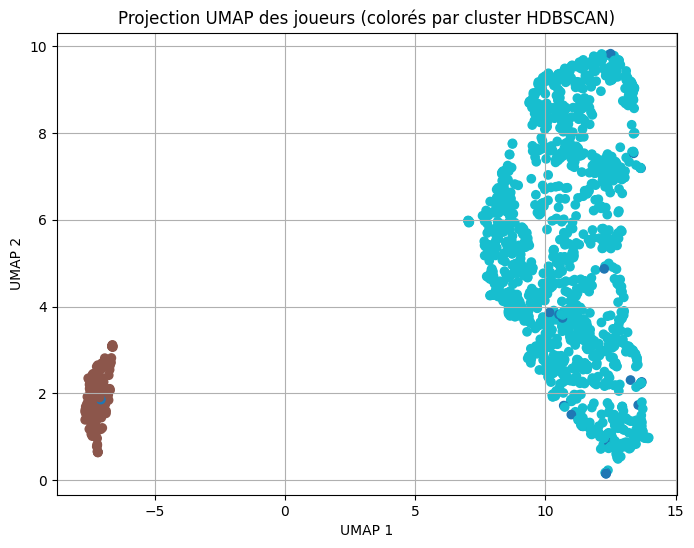

In [48]:
import umap.umap_ as umap

# Réduction à 2D pour visualisation
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Visualisation
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='tab10')
plt.title("Projection UMAP des joueurs (colorés par cluster HDBSCAN)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


Le graphe montre deux grands groupes très bien séparés dans l’espace UMAP.

HDBSCAN a clairement distingué :

Un petit groupe dense à gauche (profil très spécifique),

Un groupe beaucoup plus large à droite, représentant des joueurs plus variés.

Cela confirme visuellement la cohérence du clustering HDBSCAN dans un espace non linéaire.

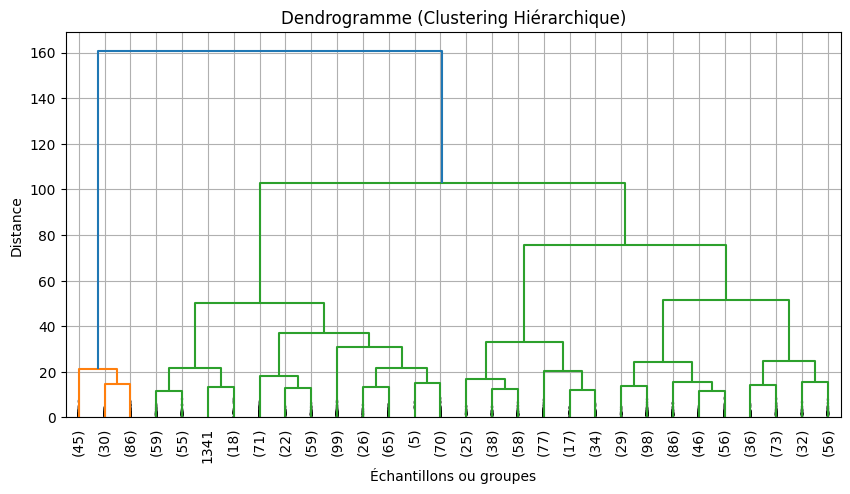

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Étape 1 : Lien hiérarchique (calcul des distances)
linked = linkage(X_pca, method='ward')  # 'ward' = minimise variance intra-cluster

# Étape 2 : Affichage du dendrogramme
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title("Dendrogramme (Clustering Hiérarchique)")
plt.xlabel("Échantillons ou groupes")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


In [45]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')

labels_agglo = agglo.fit_predict(X_pca)


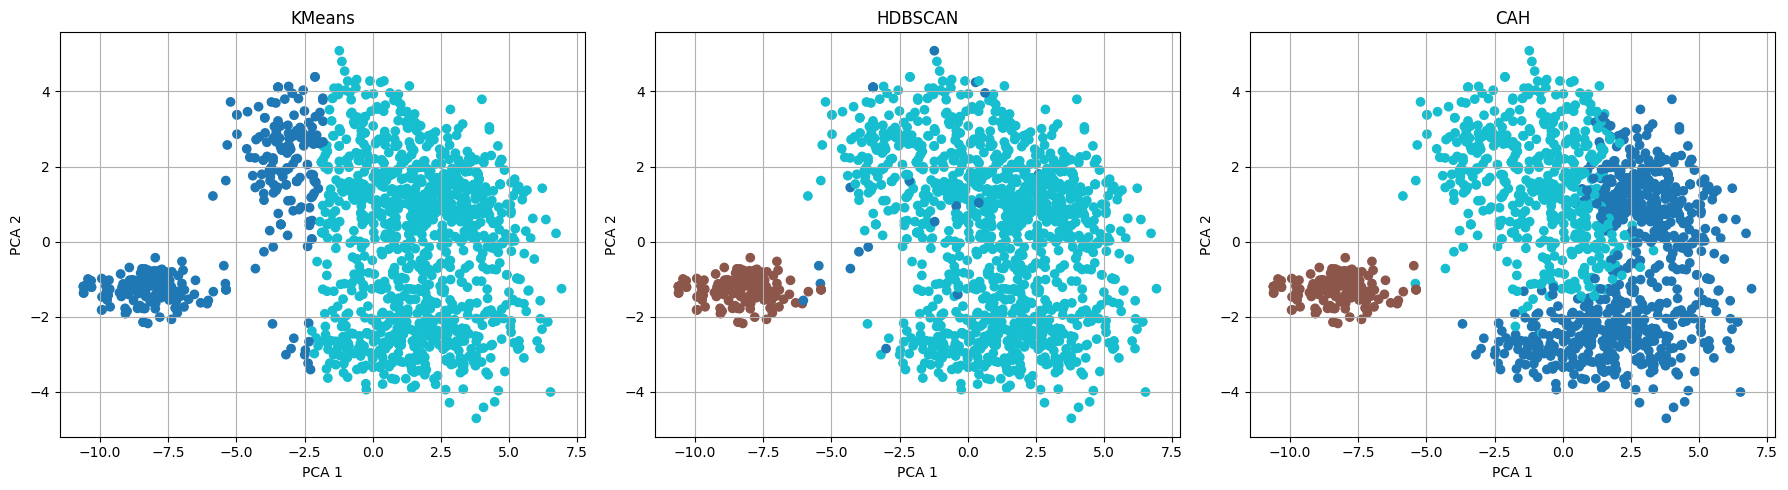

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')

axs[0].set_title("KMeans")

axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10')
axs[1].set_title("HDBSCAN")

axs[2].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_agglo, cmap='tab10')
axs[2].set_title("CAH")

for ax in axs:
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.grid(True)

plt.tight_layout()
plt.show()


 Interprétation comparative du graphique

| Méthode     | Ce qu’on observe                                        | Analyse                                                             |
| ----------- | ------------------------------------------------------- | ------------------------------------------------------------------- |
| **KMeans**  | Deux groupes clairs, bien séparés                       | Clustering propre mais rigide ; les outliers sont intégrés de force |
| **HDBSCAN** | Un groupe compact + un groupe diffus + des outliers     | Adapté aux données naturelles ; très bon pour les profils atypiques |
| **CAH**     | 3 regroupements visibles ; moins net sur les frontières | Plus flexible ; reflète mieux des sous-groupes (hiérarchie interne) |


Critères de décision

| Critère                                      | Objectif                                                         |
| -------------------------------------------- | ---------------------------------------------------------------- |
| 1. **Cohérence des groupes**                 | Les joueurs dans un même groupe doivent être vraiment similaires |
| 2. **Capacité à gérer les cas particuliers** | Gérer les outliers ou profils atypiques                          |
| 3. **Flexibilité et réalisme**               | Refléter des structures naturelles du football                   |


Comparatif des 3 méthodes

| Méthode     | Cohérence interne                      | Gestion des profils atypiques   | Interprétabilité        | Recommandée pour             |
| ----------- | -------------------------------------- | ------------------------------- | ----------------------- | ---------------------------- |
| **KMeans**  | ✅✅ Bonne, mais forcée en 2 groupes     | ❌ Aucun outlier, tout est forcé | ✅ Facile à lire         | Cas simple, baseline         |
| **HDBSCAN** | ✅✅✅ Très forte, détecte densité réelle | ✅✅✅ Oui (−1 = outliers)         | ✅ Moyenne mais réaliste | 🔥 Recommandé                |
| **CAH**     | ✅ Nuancé, flexible                     | ❌ Pas d'outlier                 | ✅✅ Hiérarchique         | Bon pour visualisation/arbre |


Pour le système de recommandation de joueurs similaires :

on Utilise HDBSCAN comme méthode principale de clustering.

Pourquoi ?

Il identifie automatiquement les groupes naturels, sans imposer un K.

Il gère très bien les joueurs atypiques → essentiel pour du scouting ou des profils hybrides.

Il produit des groupes plus cohérents et flexibles, bien adaptés à la diversité des rôles en football.

In [58]:
import pandas as pd
import os
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan

# === 1. Chargement du dataset brut ===
df = pd.read_excel("merged_players.xlsx")  # Remplace par ton chemin réel

# === 2. Définir les features utilisées ===
features = [
    'ballcontrol', 'vision', 'finishing', 'balance',
    'agility', 'sprintspeed',  'reactions',
    'positioning', 'marking', 'standingtackle', 'slidingtackle',
    'interceptions', 'headingaccuracy', 'volleys',
    'longshots', 'curve', 'fkaccuracy', 'longpassing',
    'crossing', 'shortpassing', 'dribbling','shotpower', 'strength', 'penalties'
]

# === 3. Préparation des données ===
df_cleaned = df.dropna(subset=features).copy()
X = df_cleaned[features]

# === 4. Entraînement du scaler ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 5. Réduction de dimension avec PCA ===
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

# === 6. Clustering avec HDBSCAN ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, prediction_data=True)
cluster_labels = clusterer.fit_predict(X_pca)

# Ajout des labels au DataFrame
df_cleaned["cluster"] = cluster_labels

# === 7. Sauvegarde des objets et données ===
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Sauvegarde des modèles
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")
joblib.dump(clusterer, "models/hdbscan_model.pkl")

# Sauvegarde des features utilisées
with open("models/features_used.json", "w") as f:
    json.dump(features, f)

# Sauvegarde du DataFrame enrichi
df_cleaned.to_csv("data/clustered_players.csv", index=False)

print("✅ Pipeline complet sauvegardé avec succès.")


✅ Pipeline complet sauvegardé avec succès.


c:\Users\bahri\Desktop\Football_performance_analysis\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\bahri\Desktop\Football_performance_analysis\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
